In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

# Cek lokasi file agar tidak error
filename = 'StudentsPerformance.csv'

if os.path.exists(filename):
    df = pd.read_csv(filename)
    print("✅ Dataset berhasil dimuat!")
    print(f"Total Siswa: {df.shape[0]}")
    display(df.head()) # 'display' khusus untuk format ipynb
else:
    print(f"❌ File '{filename}' tidak ditemukan.")
    print("Pastikan file CSV ada di folder yang sama dengan file .ipynb ini.")

✅ Dataset berhasil dimuat!
Total Siswa: 1000


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Jumlah Siswa per Kategori:
status_risiko
Aman (Lulus)     715
Berisiko (DO)    285
Name: count, dtype: int64


C:\Users\zak71\AppData\Local\Temp\ipykernel_25092\858895385.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status_risiko', data=df, palette='magma')


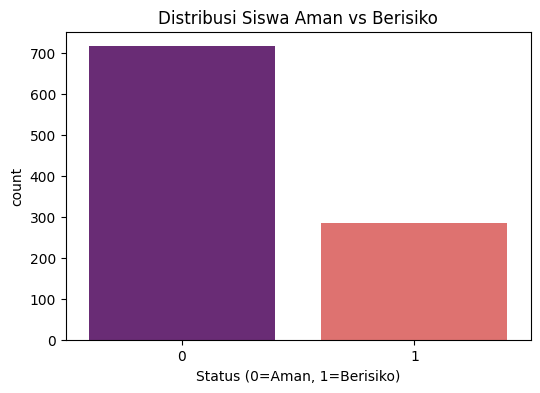

In [2]:
# 1. Hitung Rata-rata Nilai (Math + Reading + Writing)
df['average_score'] = (df['math score'] + df['reading score'] + df['writing score']) / 3

# 2. Buat Label Target (Klasifikasi)
# Jika Rata-rata < 60, maka Berisiko (1). Jika >= 60, Aman (0).
threshold = 60
df['status_risiko'] = np.where(df['average_score'] < threshold, 1, 0)

# Cek Distribusi Data
print("Jumlah Siswa per Kategori:")
print(df['status_risiko'].value_counts().rename({0: 'Aman (Lulus)', 1: 'Berisiko (DO)'}))

# Visualisasi Sederhana
plt.figure(figsize=(6, 4))
sns.countplot(x='status_risiko', data=df, palette='magma')
plt.title('Distribusi Siswa Aman vs Berisiko')
plt.xlabel('Status (0=Aman, 1=Berisiko)')
plt.show()

In [3]:
# Pisahkan Fitur (X) dan Target (y)
# Kita drop nilai ujian asli agar model hanya memprediksi berdasarkan latar belakang sosial
X = df.drop(['math score', 'reading score', 'writing score', 'average_score', 'status_risiko'], axis=1)
y = df['status_risiko']

# Encoding (Ubah Teks -> Angka)
label_encoders = {}
X_encoded = X.copy()

for col in X_encoded.columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le # Simpan encoder untuk dipakai prediksi nanti

# Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("✅ Data siap! Ukuran Training:", X_train.shape)
print("✅ Data siap! Ukuran Testing:", X_test.shape)

✅ Data siap! Ukuran Training: (800, 5)
✅ Data siap! Ukuran Testing: (200, 5)


In [4]:
# Inisialisasi Model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training Model
model.fit(X_train, y_train)
print("🤖 Model Random Forest berhasil dilatih.")

🤖 Model Random Forest berhasil dilatih.


📊 Akurasi Model: 67.50%


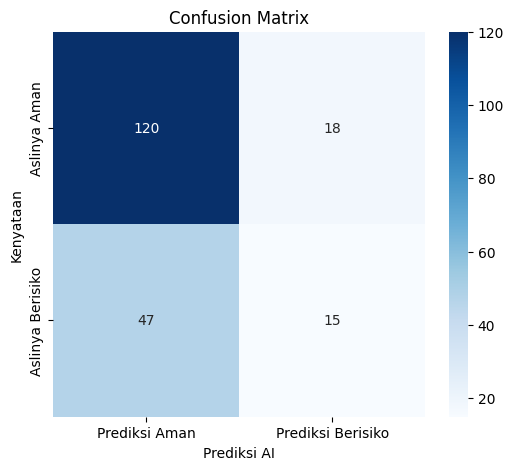

              precision    recall  f1-score   support

        Aman       0.72      0.87      0.79       138
    Berisiko       0.45      0.24      0.32        62

    accuracy                           0.68       200
   macro avg       0.59      0.56      0.55       200
weighted avg       0.64      0.68      0.64       200



In [5]:
# Prediksi data testing
y_pred = model.predict(X_test)

# Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"📊 Akurasi Model: {acc * 100:.2f}%")

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prediksi Aman', 'Prediksi Berisiko'], 
            yticklabels=['Aslinya Aman', 'Aslinya Berisiko'])
plt.title('Confusion Matrix')
plt.ylabel('Kenyataan')
plt.xlabel('Prediksi AI')
plt.show()

# Laporan Detail
print(classification_report(y_test, y_pred, target_names=['Aman', 'Berisiko']))

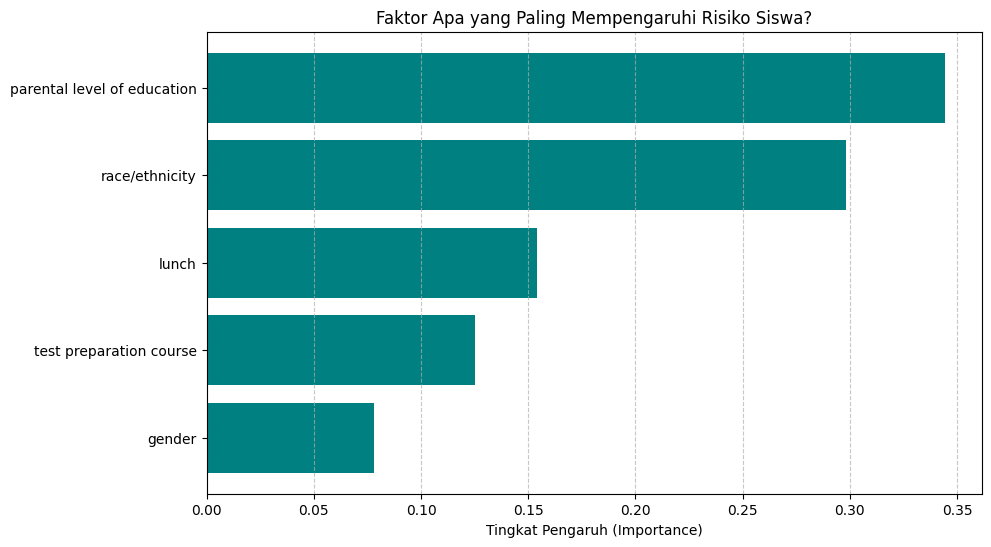

In [6]:
# Ambil data importance
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)

# Plotting Grafik Batang
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Tingkat Pengaruh (Importance)')
plt.title('Faktor Apa yang Paling Mempengaruhi Risiko Siswa?')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# --- UBAH DATA DI SINI UNTUK MENCOBA ---
siswa_baru = {
    'gender': 'male',                      # options: female, male
    'race/ethnicity': 'group C',           # options: group A, B, C, D, E
    'parental level of education': 'high school', # options: master's degree, high school, bachelor's degree
    'lunch': 'free/reduced',               # options: standard, free/reduced
    'test preparation course': 'none'      # options: none, completed
}
# ---------------------------------------

# Proses Prediksi
input_df = pd.DataFrame([siswa_baru])
input_ready = input_df.copy()

try:
    for col in input_df.columns:
        input_ready[col] = label_encoders[col].transform(input_df[col])

    prediksi = model.predict(input_ready)[0]
    probabilitas = model.predict_proba(input_ready)[0]

    status = "⚠️ BERISIKO (DO)" if prediksi == 1 else "✅ AMAN (Lulus)"
    
    print("--- HASIL PREDIKSI SISTEM ---")
    print(f"Profil: {siswa_baru['gender']}, Makan Siang: {siswa_baru['lunch']}, Ortu: {siswa_baru['parental level of education']}")
    print(f"Prediksi: {status}")
    print(f"Kepastian (Confidence): {max(probabilitas)*100:.1f}%")

except Exception as e:
    print(f"Error: {e}")
    print("Pastikan penulisan data input persis sama dengan opsi yang ada di dataset.")

--- HASIL PREDIKSI SISTEM ---
Profil: male, Makan Siang: free/reduced, Ortu: high school
Prediksi: ⚠️ BERISIKO (DO)
Kepastian (Confidence): 63.0%
